# ECB - Extract Long-Term Interest Rates Data

This notebook extracts Long-Term Interest Rates data from ECB CSV files for multiple European countries.

The notebook:
- Reads all CSV files from `data/ecb/` directory
- Identifies the country from the filename pattern (IRS.M.[COUNTRY_CODE].L.L40.CI.0000.EUR.N.Z.csv)
- Extracts DATE and Long-Term interest rate columns
- Saves output CSV files as `IRS_[NATION]_MONTHLY.csv` (e.g., `IRS_ITALY_MONTHLY.csv`)
- Creates plots for each country


In [1]:
import pandas as pd
import os
import glob
import warnings
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import re

warnings.filterwarnings('ignore')


In [2]:
# Change to project root directory
# Find the project root by looking for the 'data' directory
current_dir = os.getcwd()
while not os.path.exists(os.path.join(current_dir, 'data')):
    parent_dir = os.path.dirname(current_dir)
    if parent_dir == current_dir:
        # Reached filesystem root without finding 'data' directory
        raise FileNotFoundError("Could not find project root directory (looking for 'data' folder)")
    current_dir = parent_dir

os.chdir(current_dir)
print(f"Working directory: {os.getcwd()}")

# Define input directory
input_dir = 'data/ecb'
output_dir = 'data/ecb'

# Check that the input directory exists
if not os.path.exists(input_dir):
    raise FileNotFoundError(f"Directory not found: {input_dir}")

print(f"Input directory: {input_dir}")
print(f"Output directory: {output_dir}")


Working directory: /workspace
Input directory: data/ecb
Output directory: data/ecb


In [3]:
# Mapping of country codes to full country names
# Pattern: IRS.M.[COUNTRY_CODE].L.L40.CI.0000.EUR.N.Z.csv
COUNTRY_CODE_MAP = {
    'IT': 'ITALY',
    'FR': 'FRANCE',
    'DE': 'GERMANY',
    'ES': 'SPAIN',
    'NL': 'NETHERLANDS',
    'BE': 'BELGIUM',
    'AT': 'AUSTRIA',
    'PT': 'PORTUGAL',
    'IE': 'IRELAND',
    'FI': 'FINLAND',
    'GR': 'GREECE',
    'SK': 'SLOVAKIA',
    'SI': 'SLOVENIA',
    'EE': 'ESTONIA',
    'LV': 'LATVIA',
    'LT': 'LITHUANIA',
    'CY': 'CYPRUS',
    'MT': 'MALTA',
    'LU': 'LUXEMBOURG'
}

print("Country code mapping:")
for code, name in sorted(COUNTRY_CODE_MAP.items()):
    print(f"  {code} -> {name}")


Country code mapping:
  AT -> AUSTRIA
  BE -> BELGIUM
  CY -> CYPRUS
  DE -> GERMANY
  EE -> ESTONIA
  ES -> SPAIN
  FI -> FINLAND
  FR -> FRANCE
  GR -> GREECE
  IE -> IRELAND
  IT -> ITALY
  LT -> LITHUANIA
  LU -> LUXEMBOURG
  LV -> LATVIA
  MT -> MALTA
  NL -> NETHERLANDS
  PT -> PORTUGAL
  SI -> SLOVENIA
  SK -> SLOVAKIA


In [4]:
# Find all CSV files in the ECB directory
csv_files = glob.glob(os.path.join(input_dir, 'IRS.M.*.csv'))
csv_files = [f for f in csv_files if os.path.isfile(f)]

print(f"Found {len(csv_files)} CSV file(s):")
for f in csv_files:
    print(f"  {os.path.basename(f)}")

if len(csv_files) == 0:
    raise FileNotFoundError(f"No CSV files found in {input_dir}")


Found 3 CSV file(s):
  IRS.M.DE.L.L40.CI.0000.EUR.N.Z.csv
  IRS.M.FR.L.L40.CI.0000.EUR.N.Z.csv
  IRS.M.IT.L.L40.CI.0000.EUR.N.Z.csv


In [5]:
# Function to extract country code from filename
def extract_country_code(filename):
    """
    Extract country code from filename pattern: IRS.M.[COUNTRY_CODE].L.L40.CI.0000.EUR.N.Z.csv
    """
    match = re.search(r'IRS\.M\.([A-Z]{2})\.L\.L40', filename)
    if match:
        return match.group(1)
    return None

# Function to process a single ECB CSV file
def process_ecb_file(filepath):
    """
    Process a single ECB CSV file and return DataFrame with DATE and Long-Term interest rate
    """
    # Extract country code from filename
    filename = os.path.basename(filepath)
    country_code = extract_country_code(filename)
    
    if country_code is None:
        print(f"Warning: Could not extract country code from {filename}")
        return None, None
    
    # Get country name
    country_name = COUNTRY_CODE_MAP.get(country_code, country_code)
    
    print(f"\nProcessing {filename}...")
    print(f"  Country code: {country_code}")
    print(f"  Country name: {country_name}")
    
    # Read the CSV file
    df = pd.read_csv(filepath)
    
    print(f"  Columns: {df.columns.tolist()}")
    print(f"  Shape: {df.shape}")
    
    # The third column contains the interest rate (it has a long name)
    # First column is DATE, second is TIME PERIOD, third is the interest rate
    if len(df.columns) < 3:
        print(f"  Warning: Expected at least 3 columns, found {len(df.columns)}")
        return None, None
    
    date_col = df.columns[0]
    rate_col = df.columns[2]  # Third column contains the interest rate
    
    # Extract DATE and interest rate
    df_extracted = df[[date_col, rate_col]].copy()
    df_extracted.columns = ['DATE', 'Long-Term interest rate']
    
    # Convert DATE to datetime
    df_extracted['DATE'] = pd.to_datetime(df_extracted['DATE'], format='%Y-%m-%d', errors='coerce')
    
    # Remove rows with invalid dates
    df_extracted = df_extracted[df_extracted['DATE'].notna()].copy()
    
    # Convert interest rate to numeric
    df_extracted['Long-Term interest rate'] = pd.to_numeric(
        df_extracted['Long-Term interest rate'], errors='coerce'
    )
    
    # Sort by date before applying bfill
    df_extracted = df_extracted.sort_values(by='DATE').reset_index(drop=True)
    
    # Check for missing values before bfill
    missing_before = df_extracted['Long-Term interest rate'].isna().sum()
    if missing_before > 0:
        print(f"  Missing values before bfill: {missing_before}")
        # Apply backward fill (bfill) to fill missing values
        df_extracted['Long-Term interest rate'] = df_extracted['Long-Term interest rate'].bfill()
        missing_after = df_extracted['Long-Term interest rate'].isna().sum()
        print(f"  Missing values after bfill: {missing_after}")
    
    # Remove rows with invalid interest rates (only if still present after bfill)
    df_extracted = df_extracted[df_extracted['Long-Term interest rate'].notna()].copy()
    
    print(f"  Processed {len(df_extracted)} rows")
    print(f"  Date range: {df_extracted['DATE'].min()} to {df_extracted['DATE'].max()}")
    
    return df_extracted, country_name


In [6]:
# Process all files
processed_data = {}

for csv_file in csv_files:
    df_processed, country_name = process_ecb_file(csv_file)
    
    if df_processed is not None and country_name is not None:
        processed_data[country_name] = df_processed

print(f"\n\nSuccessfully processed {len(processed_data)} file(s):")
for country in sorted(processed_data.keys()):
    print(f"  {country}: {len(processed_data[country])} rows")



Processing IRS.M.DE.L.L40.CI.0000.EUR.N.Z.csv...
  Country code: DE
  Country name: GERMANY
  Columns: ['DATE', 'TIME PERIOD', 'Long-term interest rate for convergence purposes - 10 years maturity, denominated in Euro - Germany (IRS.M.DE.L.L40.CI.0000.EUR.N.Z)']
  Shape: (430, 3)
  Processed 430 rows
  Date range: 1990-01-31 00:00:00 to 2025-10-31 00:00:00

Processing IRS.M.FR.L.L40.CI.0000.EUR.N.Z.csv...
  Country code: FR
  Country name: FRANCE
  Columns: ['DATE', 'TIME PERIOD', 'Long-term interest rate for convergence purposes - 10 years maturity, denominated in Euro - France (IRS.M.FR.L.L40.CI.0000.EUR.N.Z)']
  Shape: (478, 3)
  Processed 478 rows
  Date range: 1986-01-31 00:00:00 to 2025-10-31 00:00:00

Processing IRS.M.IT.L.L40.CI.0000.EUR.N.Z.csv...
  Country code: IT
  Country name: ITALY
  Columns: ['DATE', 'TIME PERIOD', 'Long-term interest rate for convergence purposes - 10 years maturity, denominated in Euro - Italy (IRS.M.IT.L.L40.CI.0000.EUR.N.Z)']
  Shape: (416, 3)
  Pr

Saved: data/ecb/IRS_GERMANY_MONTHLY.csv
Plot saved: data/ecb/IRS_GERMANY_MONTHLY_plot.png


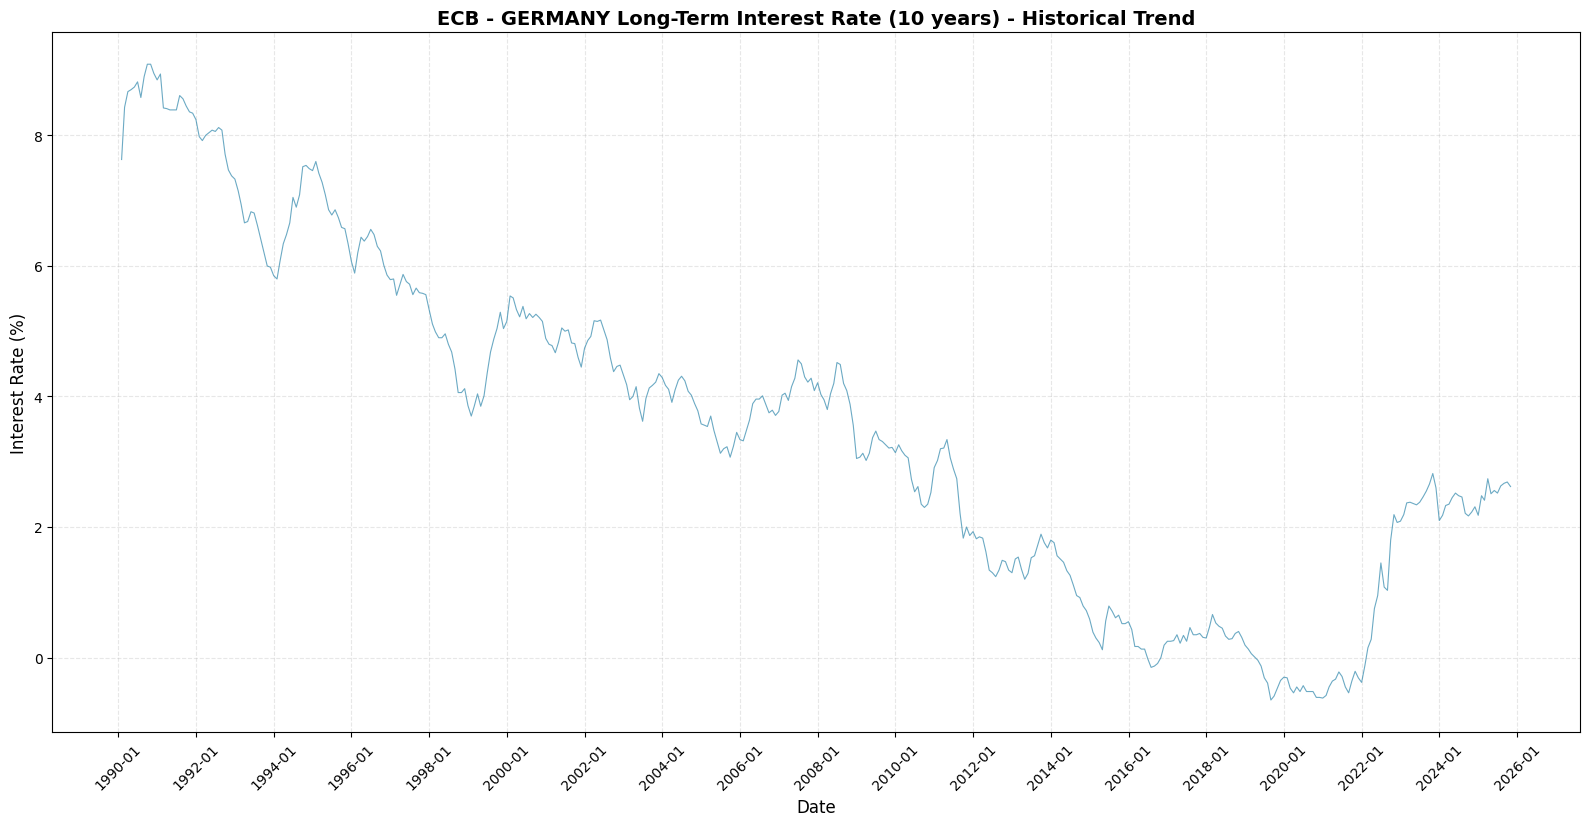


Saved: data/ecb/IRS_FRANCE_MONTHLY.csv
Plot saved: data/ecb/IRS_FRANCE_MONTHLY_plot.png


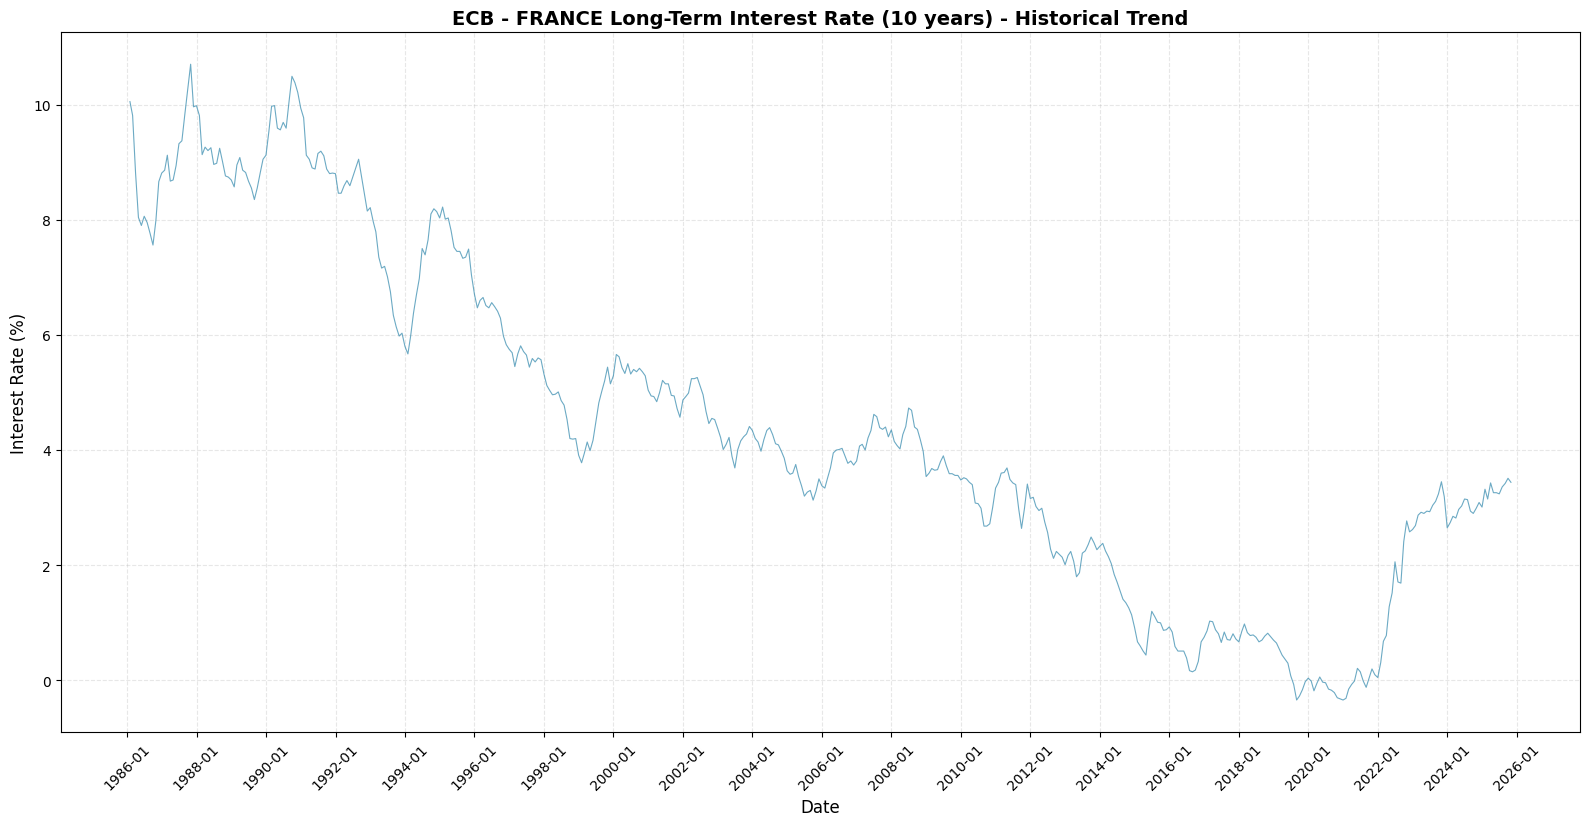


Saved: data/ecb/IRS_ITALY_MONTHLY.csv
Plot saved: data/ecb/IRS_ITALY_MONTHLY_plot.png


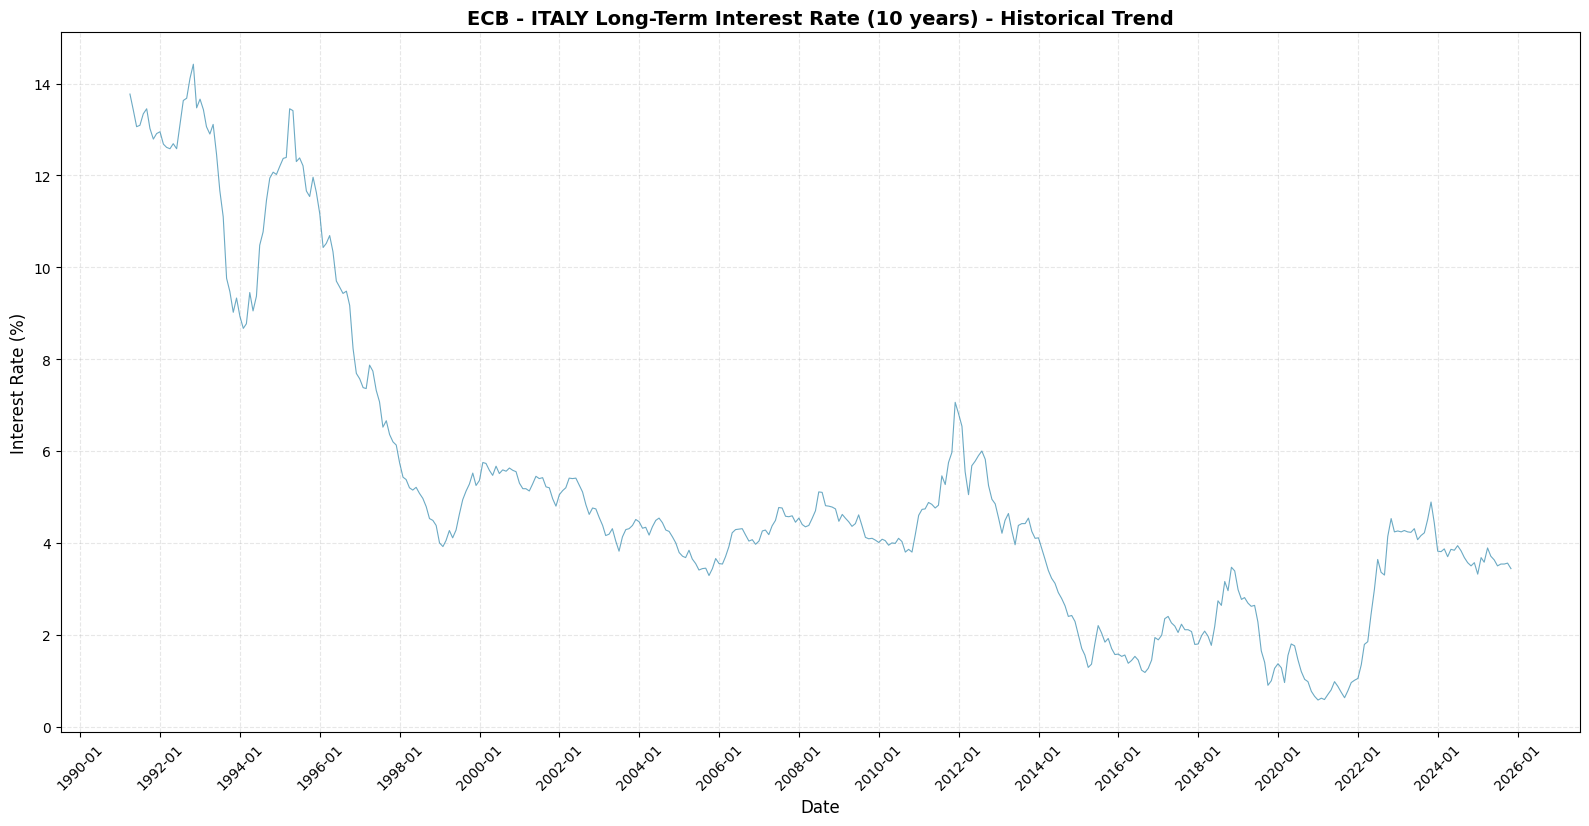

In [7]:
# Save CSV files and create plots
os.makedirs(output_dir, exist_ok=True)

for country_name, df_data in processed_data.items():
    # Create output filename
    output_filename = f'IRS_{country_name}_MONTHLY.csv'
    output_path = os.path.join(output_dir, output_filename)
    
    # Format date as string for CSV
    df_to_save = df_data.copy()
    df_to_save['DATE'] = df_to_save['DATE'].dt.strftime('%Y-%m-%d')
    
    # Save CSV
    df_to_save.to_csv(output_path, index=False)
    print(f"Saved: {output_path}")
    
    # Create plot
    plt.figure(figsize=(16, 8))
    plt.plot(df_data['DATE'], df_data['Long-Term interest rate'], 
             linewidth=0.8, color='#2E86AB', alpha=0.7)
    plt.title(f'ECB - {country_name} Long-Term Interest Rate (10 years) - Historical Trend', 
              fontsize=14, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Interest Rate (%)', fontsize=12)
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.tight_layout()
    
    # Format x-axis dates
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))  # Show every 2 years
    plt.xticks(rotation=45)
    
    # Save plot
    plot_filename = f'IRS_{country_name}_MONTHLY_plot.png'
    plot_path = os.path.join(output_dir, plot_filename)
    plt.savefig(plot_path, dpi=150, bbox_inches='tight')
    print(f"Plot saved: {plot_path}")
    
    plt.show()
    
    print()
